In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
%matplotlib inline

In [2]:
class ExperimentalDataReader():
    
    def __init__(self):
        '''
        Class constructor.
        Creates an instance of ExperimentalDataReader class with empty data DataFrame.
        '''

        self.data = pd.DataFrame(columns=['time', 
                                          'frequency_hz', 
                                          'dlts_v', 
                                          'temperature_k',
                                          'dlts_pf',
                                          'bs',
                                          'ls',
                                          'f_pulse',
                                          'u1',
                                          'ur',
                                          'time_between_meas',
                                          'integral_time',
                                          'sample_name'])
        
        
    def read_from_d_t(self, d_file_name, t_file_name, encoding='cp1251'):
        '''
        Read data from text files with experimental data, merge them, and write to self.data
        
        Parameters
        ----------
        d_file_name : string 
            String containing the name of the file with temperature
        t_file_name : string
            String containing the name of the file with DLTS.
        encoding : string
            Encoding of text files with experimental data. 
            Encodings for both files must be the same. Default value is 'cp1251'.
        '''
        
        dlts_data = pd.read_csv(d_file_name, 
                                sep=' ',
                                encoding=encoding,
                                comment='#',
                                skipinitialspace=True,
                                usecols=[0, 2, 3],
                                header=None,
                                names=['time', 'frequency_hz', 'dlts_v'])
        
        temperature_data = pd.read_csv(t_file_name,
                                       sep='[;\s]+',
                                       encoding=encoding,
                                       usecols=[0, 3],
                                       header=None,
                                       names=['time', 'temperature_k'],
                                       skiprows=1,
                                       engine='python')
        
        with open(d_file_name, 'r') as f:
            date_str = re.findall('\d\d\.\d\d\.\d\d\d\d', f.read())
        
        dlts_data['time'] = dlts_data.time + ' ' + date_str
        dlts_data['time'] = pd.to_datetime(dlts_data.time, format='%H:%M:%S %d.%m.%Y')
        
        temperature_data['time'] = temperature_data.time + ' ' + date_str
        temperature_data['time'] = pd.to_datetime(temperature_data.time, format='%H:%M:%S %d.%m.%Y')
        
        temperature_data.set_index('time', inplace=True)
        temperature_data = temperature_data.resample('S').ffill()
        
        column_list = ['time', 'frequency_hz', 'dlts_v', 'temperature_k']
        self.data[column_list] = dlts_data.merge(right=temperature_data, how='left', on='time')
    
    
    def read_from_csv(self, fname):
        self.data = pd.read_csv(fname)
    
    
    def read_from_hdf(self, fname, key=None):
        if key is None:
            self.data = pd.read_hdf(fname)
        else:
            self.data = pd.read_hdf(fname, key)
    
    
    def set_sample_name(self, sample_name):
        self.data.sample_name = sample_name
    
    
    def set_bs(self, bs=np.nan):
        self.data.bs = bs
    
    
    def set_ls(self, ls=np.nan):
        self.data.ls = ls
    
    
    def set_f_pulse(self, f_pulse=np.nan):
        self.data.f_pulse = f_pulse
    
    
    def set_u1(self, u1=np.nan):
        self.data.u1 = u1
    
    
    def set_ur(self, ur=np.nan):
        self.data.ur = ur
        
        
    def set_time_between_meas(self, time=np.nan):
        self.data.time_between_meas = time
    
    
    def set_integral_time(self, time=np.nan):
        self.data.integral_time = time
    
    def compute_dlts_pf(self):
        self.data.dlts_pf = self.data.dlts_v / ((10 / self.data.bs)*(10000 / self.data.ls))

    
    def to_csv(self, fname):
        self.data.to_csv(fname, index=False)
    
    
    def to_hdf(self, fname, key='data'):
        self.data.to_hdf(fname, key)
        
    
    def get_plot(self):
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})
        
        self.data.plot(ax=ax[0],
                       x='frequency_hz',
                       y='dlts_pf',
                       kind='scatter',
                       logx=True,
                       xlabel='Frequency, Hz',
                       ylabel='DLTS, pF',
                       grid=True,
                      )
        
        self.data.plot(ax=ax[1],
                       x='frequency_hz',
                       y='temperature_k',
                       kind='scatter',
                       logx=True,
                       xlabel='Frequency, Hz',
                       ylabel='Temperature, K',
                       grid=True,
                       ylim=(np.round(self.data.temperature_k.min() - 1, 0), np.round(self.data.temperature_k.max() + 1, 0))
                      )
        
        return fig, ax

In [3]:
data_reader = ExperimentalDataReader()

folder = '.experimental_data\\'
d_file_name = folder + 'КТ117№3_п1(база 2)_2500Гц-1Гц_1пФ_20С_-1В-12В_100мВ_20мкс_шаг_0,1'
t_file_name = folder + 'Температура_КТ117№3_п1(база 2)_2500Гц-1Гц_1пФ_20С_-1В-12В_100мВ_20мкс_шаг_0,1.txt'

data_reader.read_from_d_t(d_file_name=d_file_name, t_file_name=t_file_name)

data_reader.set_bs(1)

data_reader.set_ls(100)

data_reader.set_f_pulse(20)

data_reader.compute_dlts_pf()

data_reader.set_sample_name('КТ117№3_п1(база 2)')

data_reader.set_u1(-1.0)

data_reader.set_ur(-12.0)

data_reader.set_time_between_meas(3.5)

data_reader.set_integral_time(3.0)

data_reader.data.head()

time  frequency_hz  dlts_v  temperature_k   dlts_pf  bs   ls  \
0 2021-12-01 15:06:10     2500.0000  -2.182        293.206 -0.002182   1  100   
1 2021-12-01 15:06:14     1985.8207  -2.296        293.204 -0.002296   1  100   
2 2021-12-01 15:06:18     1577.3937  -2.635        293.207 -0.002635   1  100   
3 2021-12-01 15:06:22     1252.9686  -3.020        293.199 -0.003020   1  100   
4 2021-12-01 15:06:26      995.2686  -3.540        293.207 -0.003540   1  100   

   f_pulse   u1    ur  time_between_meas  integral_time         sample_name  
0       20 -1.0 -12.0                3.5            3.0  КТ117№3_п1(база 2)  
1       20 -1.0 -12.0                3.5            3.0  КТ117№3_п1(база 2)  
2       20 -1.0 -12.0                3.5            3.0  КТ117№3_п1(база 2)  
3       20 -1.0 -12.0                3.5            3.0  КТ117№3_п1(база 2)  
4       20 -1.0 -12.0                3.5            3.0  КТ117№3_п1(база 2)

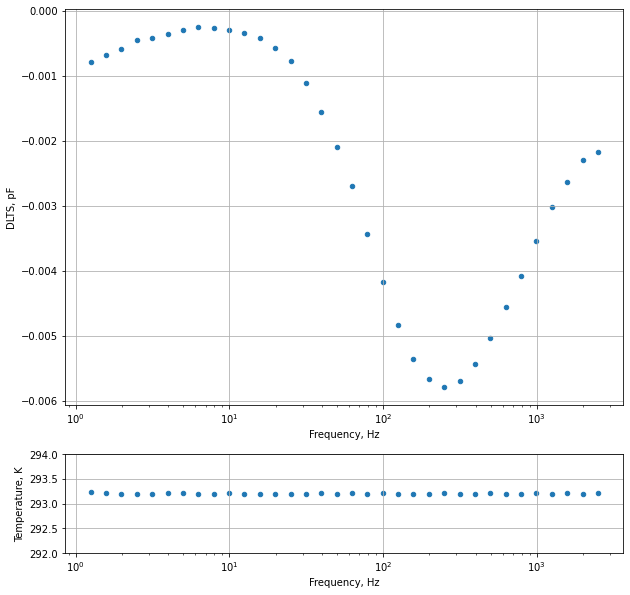

In [4]:
data_reader.get_plot()

plt.savefig(folder + 'КТ117№3_п1(база 2)_2500Гц-1Гц_1пФ_20С_-1В-12В_100мВ_20мкс_шаг_0,1.jpg')
plt.savefig(folder + 'КТ117№3_п1(база 2)_2500Гц-1Гц_1пФ_20С_-1В-12В_100мВ_20мкс_шаг_0,1.svg')

plt.show()